# **MaskRCNN Instance Segmentation**
***

In [1]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import json
import numpy as np
import cv2
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import matplotlib.patches as patches
import random
import time
import labelme2coco

***
**Dataset generieren**

In [2]:
train_labelme_folder = r"/home/mo/MaskRCNN_InstanceSeg/imgs/train_imgs"
train_output_folder = r"/home/mo/MaskRCNN_InstanceSeg/annotations/train"

val_labelme_folder = r"/home/mo/MaskRCNN_InstanceSeg/imgs/val_imgs"
val_output_folder = r"/home/mo/MaskRCNN_InstanceSeg/annotations/val"

test_labelme_folder = r"/home/mo/MaskRCNN_InstanceSeg/imgs/test_imgs"
test_output_folder = r"/home/mo/MaskRCNN_InstanceSeg/annotations/test"

In [3]:
labelme2coco.convert(train_labelme_folder, train_output_folder, category_id_start=1)
labelme2coco.convert(val_labelme_folder, val_output_folder, category_id_start=1)
labelme2coco.convert(test_labelme_folder, test_output_folder, category_id_start=1)


There are 213 listed files in folder train_imgs.


Converting labelme annotations to COCO format: 100%|██████████| 213/213 [00:00<00:00, 365.83it/s]
01/15/2025 16:20:57 - INFO - labelme2coco -   Converted annotations in COCO format is exported to /home/mo/MaskRCNN_InstanceSeg/annotations/train/dataset.json


There are 31 listed files in folder val_imgs.


Converting labelme annotations to COCO format: 100%|██████████| 31/31 [00:00<00:00, 392.50it/s]
01/15/2025 16:20:58 - INFO - labelme2coco -   Converted annotations in COCO format is exported to /home/mo/MaskRCNN_InstanceSeg/annotations/val/dataset.json


There are 31 listed files in folder test_imgs.


Converting labelme annotations to COCO format: 100%|██████████| 31/31 [00:00<00:00, 424.57it/s]
01/15/2025 16:20:58 - INFO - labelme2coco -   Converted annotations in COCO format is exported to /home/mo/MaskRCNN_InstanceSeg/annotations/test/dataset.json


In [4]:
def validate_and_fix_coco_dataset(coco_path, output_path):
    with open(coco_path, 'r', encoding='utf-8') as f:
        coco_data = json.load(f)
    
    annotations = coco_data.get('annotations', [])
    valid_annotations = []
    invalid_annotations = []

    for ann in annotations:
        if 'bbox' in ann and len(ann['bbox']) == 4:
            x, y, w, h = ann['bbox']
            if w > 0 and h > 0:
                valid_annotations.append(ann)
            else:
                invalid_annotations.append(ann)
        else:
            invalid_annotations.append(ann)

    coco_data['annotations'] = valid_annotations

    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(coco_data, f, ensure_ascii=False, indent=4)

    print(f"Originale Anzahl von Annotationen: {len(annotations)}")
    print(f"Anzahl gültiger Annotationen: {len(valid_annotations)}")
    print(f"Anzahl gelöschter fehlerhafter Annotationen: {len(invalid_annotations)}")

    if invalid_annotations:
        print("Fehlerhafte Annotationen:")
        for invalid_ann in invalid_annotations:
            print(invalid_ann)

In [5]:
coco_file_path = r"/home/mo/MaskRCNN_InstanceSeg/annotations/train/dataset.json"
output_file_path = r"/home/mo/MaskRCNN_InstanceSeg/annotations/train/dataset_cleaned.json"
validate_and_fix_coco_dataset(coco_file_path, output_file_path)

coco_file_path = r"/home/mo/MaskRCNN_InstanceSeg/annotations/val/dataset.json"
output_file_path = r"/home/mo/MaskRCNN_InstanceSeg/annotations/val/dataset_cleaned.json"
validate_and_fix_coco_dataset(coco_file_path, output_file_path)

coco_file_path = r"/home/mo/MaskRCNN_InstanceSeg/annotations/test/dataset.json"
output_file_path = r"/home/mo/MaskRCNN_InstanceSeg/annotations/test/dataset_cleaned.json"
validate_and_fix_coco_dataset(coco_file_path, output_file_path)

Originale Anzahl von Annotationen: 2660
Anzahl gültiger Annotationen: 2657
Anzahl gelöschter fehlerhafter Annotationen: 3
Fehlerhafte Annotationen:
{'iscrowd': 0, 'image_id': 62, 'bbox': [], 'segmentation': [], 'category_id': 2, 'id': 855, 'area': 0}
{'iscrowd': 0, 'image_id': 187, 'bbox': [], 'segmentation': [], 'category_id': 2, 'id': 2263, 'area': 0}
{'iscrowd': 0, 'image_id': 200, 'bbox': [], 'segmentation': [], 'category_id': 2, 'id': 2440, 'area': 0}
Originale Anzahl von Annotationen: 419
Anzahl gültiger Annotationen: 419
Anzahl gelöschter fehlerhafter Annotationen: 0
Originale Anzahl von Annotationen: 419
Anzahl gültiger Annotationen: 419
Anzahl gelöschter fehlerhafter Annotationen: 0


***
**Dataset laden**

In [6]:
class CustomCocoDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transforms=None):
        """
        Initialisiere das COCO-Dataset.
        
        :param annotations_file: Pfad zur COCO-Annotationsdatei (JSON)
        :param img_dir: Verzeichnis, in dem die Bilder gespeichert sind
        :param transforms: Optional: Transformationen, die auf die Bilder angewendet werden
        """
        with open(annotations_file, 'r') as f:
            self.data = json.load(f)
        
        self.img_dir = img_dir
        self.transforms = transforms
        
        # Mapping der Bild-IDs zu den Bilddateinamen
        self.img_dict = {img['id']: img for img in self.data['images']}
        self.annotations = self.data['annotations']
        self.categories = {cat['id']: cat['name'] for cat in self.data['categories']}
        
    def __len__(self):
        """Gibt die Anzahl der Bilder im Datensatz zurück."""
        return len(self.data['images'])

    def __getitem__(self, idx):
        """Lädt das Bild und die dazugehörigen Annotationsdaten."""
        # Hole das Bild und die zugehörigen Annotationsdaten
        img_info = self.data['images'][idx]
        img_id = img_info['id']
        img_path = img_info['file_name']
        
        # Öffne das Bild (nun RGB)
        img = Image.open(img_path).convert("L")
        
        # Extrahiere die Annotations für das Bild
        annotations = [ann for ann in self.annotations if ann['image_id'] == img_id]
        
        # Extrahiere Bounding Boxes, Labels und Masken
        boxes = []
        labels = []
        masks = []
        areas = []
        iscrowd = []
        
        for ann in annotations:
            # Bounding Box [x_min, y_min, width, height] -> [x_min, y_min, x_max, y_max]
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            
            # Label der Klasse (hier: 1 für 'hook', 2 für 'bar', 3 für 'tip')
            labels.append(ann['category_id'])
            
            # Masken erstellen
            mask = np.zeros((img.height, img.width), dtype=np.uint8)
            if ann['segmentation']:
                for seg in ann['segmentation']:
                    poly = np.array(seg).reshape((int(len(seg)/2), 2))
                    cv2.fillPoly(mask, [poly], color=1)
            masks.append(mask)
            
            # Fläche des Objekts
            areas.append(ann['area'])
            
            # Crowd (0 = kein Crowd, 1 = Crowd)
            iscrowd.append(ann['iscrowd'])
        
        # Konvertiere Listen in Tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = np.array(masks)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        # masks = torch.as_tensor(masks, dtype=torch.uint8)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)
        
        # Ziel-Daten erstellen
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'area': areas,
            'iscrowd': iscrowd
        }
        
        # Transformationen anwenden, wenn sie angegeben sind
        if self.transforms:
            img = self.transforms(img)
        
        return img, target

In [7]:
TRAIN_annotations_file = r"/home/mo/MaskRCNN_InstanceSeg/annotations/train/dataset_cleaned.json"
TRAIN_img_dir = r"/home/mo/MaskRCNN_InstanceSeg/imgs/train_imgs"

VAL_annotations_file = r"/home/mo/MaskRCNN_InstanceSeg/annotations/val/dataset_cleaned.json"
VAL_img_dir = r"/home/mo/MaskRCNN_InstanceSeg/imgs/val_imgs"

TEST_annotations_file = r"/home/mo/MaskRCNN_InstanceSeg/annotations/test/dataset_cleaned.json"
VAL_img_dir = r"/home/mo/MaskRCNN_InstanceSeg/imgs/test_imgs"

In [8]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = CustomCocoDataset(annotations_file=TRAIN_annotations_file, img_dir=TRAIN_img_dir, transforms=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

val_dataset = CustomCocoDataset(annotations_file=VAL_annotations_file, img_dir=VAL_img_dir, transforms=transform)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

**Modell**

In [9]:
'''
# Lade das vortrainierte Mask R-CNN Modell mit einem ResNet50 Backbone und FPN (Feature Pyramid Networks)
model = maskrcnn_resnet50_fpn(pretrained=True)

# Die Anzahl der Klassen in deinem Dataset (4: Hintergrund + 3 Klassen)
num_classes = 5  # Hintergrund + 3 spezifische Klassen (hook, tip, lowpoint, bar)

# Ersetze die Klassifikations- und Masken-Köpfe des vortrainierten Modells
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor.cls_score = torch.nn.Linear(in_features, num_classes)
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Auch die Maske für das Modell anpassen (wenn Masken verwendet werden)
in_mask_features = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor.conv5_mask = torch.nn.Conv2d(in_mask_features, num_classes, kernel_size=1)
#model.roi_heads.mask_predictor = MaskRCNNPredictor(in_mask_features, num_classes)
'''

'\n# Lade das vortrainierte Mask R-CNN Modell mit einem ResNet50 Backbone und FPN (Feature Pyramid Networks)\nmodel = maskrcnn_resnet50_fpn(pretrained=True)\n\n# Die Anzahl der Klassen in deinem Dataset (4: Hintergrund + 3 Klassen)\nnum_classes = 5  # Hintergrund + 3 spezifische Klassen (hook, tip, lowpoint, bar)\n\n# Ersetze die Klassifikations- und Masken-Köpfe des vortrainierten Modells\nin_features = model.roi_heads.box_predictor.cls_score.in_features\nmodel.roi_heads.box_predictor.cls_score = torch.nn.Linear(in_features, num_classes)\n# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)\n\n# Auch die Maske für das Modell anpassen (wenn Masken verwendet werden)\nin_mask_features = model.roi_heads.mask_predictor.conv5_mask.in_channels\nmodel.roi_heads.mask_predictor.conv5_mask = torch.nn.Conv2d(in_mask_features, num_classes, kernel_size=1)\n#model.roi_heads.mask_predictor = MaskRCNNPredictor(in_mask_features, num_classes)\n'

In [10]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
# print(model.backbone.body.conv1)

/home/mo/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mo/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# Prüfen, ob CUDA verfügbar ist
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Schiebe das Modell auf die GPU
model = model.to(device)

print("Using GPU!") if torch.cuda.is_available else print("Using CPU!")

Using GPU!


**Training/Validation**

In [12]:
train_mode = False

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [14]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    # Die Verlustfunktion (Loss) für das Training
    total_loss = 0

    for images, targets in data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Optimierer auf Null setzen (Gradienten zurücksetzen)
        optimizer.zero_grad()

        # Vorwärtsdurchlauf
        loss_dict = model(images, targets)

        # Gesamter Verlust
        losses = sum(loss for loss in loss_dict.values())

        # Verluste zurückpropagieren und den Optimierer anpassen
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    return total_loss / len(data_loader)

In [15]:
def evaluate(model, data_loader, device):
    model.train()
    results = []
    total_loss = 0
    for images, targets in data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        '''
        with torch.no_grad():
            # Vorwärtsdurchlauf ohne Gradientenspeicherung
            prediction = model(images)

        results.append(prediction)
        '''
        results = None

    return results, total_loss

In [16]:
num_epochs = 10
val_every = 2

trainlosses_over_epochs = []
vallosses_over_epochs = []
val_epochs = []

epoch_durations = []
val_durations = []

if train_mode:
    for epoch in range(num_epochs):
        print()
        print("-------------------- TRAINING --------------------")
        epoch_start_time = time.time()
    
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
        print(f"Epoche [{epoch + 1}/{num_epochs}] Loss: {train_loss}")
        trainlosses_over_epochs.append(train_loss)
    
        val_duration = 0
        if (epoch + 1) % val_every == 0:
            print()
            print("-------------------- VALIDATION --------------------")
            val_start_time = time.time()
            results, val_loss = evaluate(model, val_loader, device)
            val_end_time = time.time()
            
            val_duration = val_end_time - val_start_time
            val_durations.append(val_duration)
            
            vallosses_over_epochs.append(val_loss)
            val_epochs.append(epoch + 1)
            print(f"Epoche [{epoch + 1}/{num_epochs}] Loss: {val_loss}")
            print()
    
            if val_loss < min(vallosses_over_epochs):
                torch.save(model.state_dict(), 'maskrcnn_trained_model.pth')
        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_durations.append(epoch_duration)
        
        avg_train_duration = sum(epoch_durations) / len(epoch_durations)
        avg_val_duration = sum(val_durations) / len(val_durations) if val_durations else 0
        remaining_epochs = num_epochs - (epoch + 1)
        remaining_val_epochs = remaining_epochs // val_every
        
        estimated_time_left = (remaining_epochs * avg_train_duration) + (remaining_val_epochs * avg_val_duration)
        
        print(f"Epoche [{epoch + 1}] Dauer: {epoch_duration:.2f} Sekunden -> verbleibend: {estimated_time_left:.2f} Sekunden")

In [17]:
if train_mode:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), trainlosses_over_epochs, marker='o', label='Train Loss')
    plt.plot(val_epochs, vallosses_over_epochs, 'o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Verlauf über Epochen')
    plt.legend()
    plt.grid()
    plt.show()

***
**Test**

In [18]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [19]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
model.load_state_dict(torch.load('maskrcnn_trained_model.pth'))
model.eval()
print('Model loaded!')

/home/mo/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mo/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded!


/tmp/ipykernel_12923/294720675.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('maskrcnn_trained_model.pth'))


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [21]:
TEST_annotations_file = r"/home/mo/MaskRCNN_InstanceSeg/annotations/test/dataset_cleaned.json"
TEST_img_dir = r"/home/mo/MaskRCNN_InstanceSeg/imgs/test_imgs"

In [22]:
test_dataset = CustomCocoDataset(annotations_file=TEST_annotations_file, img_dir=TEST_img_dir, transforms=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [23]:
def test(model, data_loader, device):
    model.eval()
    results = []
    total_loss = 0

    for images, targets in data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        if targets:
            model.train()
            loss_dict = model(images, targets)
            if isinstance(loss_dict, dict):
                losses = sum(loss for loss in loss_dict.values())
                total_loss += losses.item()
            else:
                print("Unerwartetes Format von loss_dict:", type(loss_dict), loss_dict)
        
        model.eval()
        with torch.no_grad():
            prediction = model(images)
        results.append(prediction)

    return results, total_loss

In [24]:
results, test_loss = test(model, data_loader=test_loader, device=device)

In [25]:
print(test_loss)

41.44090801477432


***
**Single Image Inference**

In [26]:
def visualize_predictions_with_boxes(image, prediction, score_threshold=0.5):
    """
    Visualisiert die Vorhersagen des Modells: Nur Bounding Boxes mit Klassen.
    
    :param image: Das Bild (im Format H x W x C) als Numpy-Array.
    :param prediction: Das Vorhersage-Ergebnis des Modells.
    :param score_threshold: Die minimale Vorhersage-Wahrscheinlichkeit, um das Objekt zu zeigen.
    """
    pred_boxes = prediction[0]['boxes'].cpu().numpy()  # Vorhergesagte Bounding Boxen
    pred_labels = prediction[0]['labels'].cpu().numpy()  # Vorhergesagte Labels
    pred_scores = prediction[0]['scores'].cpu().numpy()  # Vorhersage-Wahrscheinlichkeiten

    # Visualisierung des Bildes
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    # Zeichne Bounding Boxes und Labels, nur für Objekte mit einer hohen Wahrscheinlichkeit
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        if score > score_threshold:
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min

            # Zeichne die Bounding Box
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Beschriftung mit Label und Score
            ax.text(x_min, y_min - 10, f'Class {label} ({score:.2f})', color='red', fontsize=10)

    plt.axis('off')  # Entferne Achsen
    plt.show()

In [27]:
def visualize_masks_by_class(image, prediction):
    """
    Visualisiert das Originalbild mit Masken separat für jede Klasse in einem 2x2-Raster.

    :param image: Das Originalbild (als NumPy-Array, Shape: HxWxC)
    :param prediction: Die Vorhersagen des Modells (enthält 'masks' und 'labels')
    """
    pred_masks = prediction[0]['masks'].cpu().numpy()  # Masken (Nx1xHxW)
    pred_labels = prediction[0]['labels'].cpu().numpy()  # Labels
    pred_scores = prediction[0]['scores'].cpu().numpy()  # Wahrscheinlichkeiten (Confidence)

    # Entferne Masken mit einem Confidence-Score unter einem Schwellenwert
    confidence_threshold = 0.5
    mask_indices = np.where(pred_scores > confidence_threshold)[0]

    pred_masks = pred_masks[mask_indices]
    pred_labels = pred_labels[mask_indices]

    # Definiere die Farben für jede Klasse (RGBA ohne Transparenz)
    category_colors = {
        1: (255, 0, 0, 150),
        2: (255, 0, 0, 150),
        3: (255, 0, 0, 150),
        4: (255, 0, 0, 150),
    }

    # Erstelle ein RGBA-Bild basierend auf dem Originalbild
    image = (image * 255).astype(np.uint8) if image.max() <= 1 else image
    height, width, _ = image.shape

    # Initialisiere die Subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 7))
    axes = axes.flatten()

    # Für jede Klasse ein eigenes Bild rendern
    for class_id, ax in zip(category_colors.keys(), axes):
        # Kopiere das Originalbild
        class_image = image.copy()
        overlay = np.zeros((height, width, 3), dtype=np.uint8)  # RGB für die Klasse

        # Überlagere Masken der aktuellen Klasse
        for mask, label in zip(pred_masks, pred_labels):
            if label == class_id:
                mask = mask[0]  # Entferne die erste Dimension (1xHxW -> HxW)
                mask = (mask > 0.5).astype(np.uint8)  # Binärmaske erstellen

                # Wähle die Farbe basierend auf der Klasse
                color = category_colors[class_id]

                for i in range(3):  # Für RGB-Kanäle
                    overlay[..., i] += mask * color[i]

        # Kombiniere das Originalbild mit der Maske
        combined_image = class_image.copy()
        alpha_mask = (overlay.sum(axis=2) > 0).astype(float)  # Alpha-Kanal basierend auf Maske
        for c in range(3):  # Für jeden Farbkanal
            combined_image[..., c] = (1 - alpha_mask) * combined_image[..., c] + alpha_mask * overlay[..., c]

        # Plotten des Bildes
        ax.imshow(combined_image.astype(np.uint8))
        titles = ['Background',
                  'Bar',
                  'Hook',
                  'Tip',
                  'Lowpoint']
        
        ax.set_title(f"Class {titles[class_id]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [34]:
def load_image(image_path, convert_to_tensor=True):
    """
    Lädt ein Bild und wandelt es in einen Tensor um.
    :param image_path: Pfad zum Testbild
    :return: Bild als Tensor
    """
    image = Image.open(image_path).convert("RGB")  # Konvertiere in RGB
    transform = transforms.Compose([
        transforms.ToTensor(),  # Wandelt in Tensor um
    ])
    if convert_to_tensor:
        return transform(image)
    else:
        return image


test_image_path = r'/home/mo/Bilder/Bildschirmfoto von 2025-01-14 17-22-54.png'
# test_image_path = r"/home/mo/MaskRCNN_InstanceSeg/imgs/train_imgs/image_1735916671.png"

input_img = load_image(test_image_path, convert_to_tensor=True)
input_img = input_img.to(device)

test_img = load_image(test_image_path, convert_to_tensor=False)

In [35]:
model.eval()  # Modell in Evaluierungsmodus setzen
with torch.no_grad():
    start_time = time.perf_counter()
    prediction = model([input_img])  # Vorhersage für das Bild
    end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"Inferenz-Laufzeit: {elapsed_time:.4f} Sekunden")

Inferenz-Laufzeit: 0.0866 Sekunden


In [36]:
def extract_output(results, conf_threshold=0.8):
    res = results[0]
    if len(res['boxes'].cpu().numpy()) != 0:
        boxes = res['boxes'].cpu().numpy()
    else:
        boxes = None
    
    if len(res['masks'].cpu().numpy()) != 0:
        masks = res['masks'].cpu().numpy()
        masks = masks.reshape((masks.shape[0], masks.shape[2], masks.shape[3]))
    else:
        masks = None
    
    if len(res['labels'].cpu().numpy()) != 0:
        classes = res['labels'].cpu().numpy()
    else:
        classes = None
        
    if len(res['scores'].cpu().numpy()) != 0:
        confs = res['scores'].cpu().numpy()
    else:
        confs = None

    idx_remain = np.where(confs >= conf_threshold)
    boxes = boxes[idx_remain]
    masks = masks[idx_remain]
    confs = confs[idx_remain]
    classes = classes[idx_remain]
    return boxes, masks, confs, classes


def calc_box_midpoint(box):
    return np.array([(box[0] + box[2]) / 2, (box[1] + box[3]) / 2])

def box_distance(box1, box2):
    m1 = calc_box_midpoint(box1)
    m2 = calc_box_midpoint(box2)
    return abs(np.linalg.norm(m1, m2))


def split_outputs_by_class(boxes, masks, confs, classes):
    # Klassen Indizes finden
    if boxes is not None and masks is not None and confs is not None and classes is not None:
        idx_bar = np.where(classes == 1)[0]
        idx_hooks = np.where(classes == 2)[0]
        idx_tips = np.where(classes == 3)[0]
        idx_lowpoints = np.where(classes == 4)[0]

        # Boxes splitten
        boxes_bar = boxes[idx_bar]
        boxes_hooks = boxes[idx_hooks]
        boxes_tips = boxes[idx_tips]
        boxes_lowpoints = boxes[idx_lowpoints]

        # Masks splitten
        masks_bar = masks[idx_bar]
        masks_hooks = masks[idx_hooks]
        masks_tips = masks[idx_tips]
        masks_lowpoints = masks[idx_lowpoints]

        # Confidences splitten
        confs_bar = confs[idx_bar]
        confs_hooks = confs[idx_hooks]
        confs_tips = confs[idx_tips]
        confs_lowpoints = confs[idx_lowpoints]

        return boxes_bar, masks_bar, confs_bar, boxes_hooks, masks_hooks, boxes_tips, masks_tips, boxes_lowpoints, masks_lowpoints, confs_hooks, confs_tips, confs_lowpoints
    else:
        # print("No Classes found for Split!")
        return None, None, None, None, None, None, None, None, None, None, None, None
    
def create_hook_instances(boxes_hooks, masks_hooks, 
                          boxes_tips, masks_tips, 
                          boxes_lowpoints, masks_lowpoints, 
                          confs_hooks, confs_tips, confs_lowpoints):
    hooks_dict = {}  # Dictionary für die Ergebnisse

    if boxes_hooks is not None:     # nur wenn es ueberhaupt Haken im Bild gibt
        for i, box_hook in enumerate(boxes_hooks):
            # Berechne den Mittelpunkt des aktuellen Hakens
            hook_midpoint = calc_box_midpoint(box_hook)

            # Berechne Abstände zu allen Spitzen ("tips")
            tip_distances = [np.linalg.norm(calc_box_midpoint(box_tip) - hook_midpoint) 
                             for box_tip in boxes_tips]

            # Wähle die Spitze, die am nächsten zum Haken ist
            best_tip_idx = np.argmin(tip_distances) if tip_distances else None
            if best_tip_idx is not None:
                box_tip = boxes_tips[best_tip_idx]
                mask_tip = masks_tips[best_tip_idx]
                conf_tip = confs_tips[best_tip_idx]
            else:
                # Kein Tip gefunden
                box_tip, mask_tip, conf_tip = None, None, None

            # Berechne Abstände zu allen Lowpoints
            lowpoint_distances = [np.linalg.norm(calc_box_midpoint(box_lowpoint) - hook_midpoint) 
                                  for box_lowpoint in boxes_lowpoints]

            # Wähle den Lowpoint, der am nächsten zum Haken ist
            best_lowpoint_idx = np.argmin(lowpoint_distances) if lowpoint_distances else None
            if best_lowpoint_idx is not None:
                box_lowpoint = boxes_lowpoints[best_lowpoint_idx]
                mask_lowpoint = masks_lowpoints[best_lowpoint_idx]
                conf_lowpoint = confs_lowpoints[best_lowpoint_idx]
            else:
                # Kein Lowpoint gefunden
                box_lowpoint, mask_lowpoint, conf_lowpoint = None, None, None

            # Ergebnis für den aktuellen Haken zusammenstellen
            hooks_dict[f"hook_{i + 1}"] = {
                "hook_box": box_hook,
                "hook_mask": masks_hooks[i],
                "conf_hook": confs_hooks[i],
                "tip_box": box_tip,
                "tip_mask": mask_tip,
                "conf_tip": conf_tip,
                "lowpoint_box": box_lowpoint,
                "lowpoint_mask": mask_lowpoint,
                "conf_lowpoint": conf_lowpoint,
            }

    # Sortiere das Dictionary nach der x1, y1 Koordinate der Bounding Box
    hooks_dict = dict(sorted(hooks_dict.items(), key=lambda item: (item[1]['hook_box'][0], item[1]['hook_box'][1])))

    return hooks_dict

def create_bar_instance(boxes_bar, masks_bar, confs_bar):
    bar_dict = {}
    
    if boxes_bar is not None:
        if len(boxes_bar) != 0:
            bar_dict["bar"] = {
                "bar_box": boxes_bar[np.argmax(confs_bar)] if boxes_bar is not None else None,
                "bar_mask": masks_bar[np.argmax(confs_bar)] if masks_bar is not None else None,
                "conf_bar": confs_bar[np.argmax(confs_bar)] if confs_bar is not None else None
            }
        else:
            bar_dict["bar"] = {
                "bar_box": None,
                "bar_mask": None,
                "conf_bar": None
            }
    else:
        bar_dict["bar"] = {
            "bar_box": None,
            "bar_mask": None,
            "conf_bar": None
            }
    return bar_dict

In [37]:
def plot_hooks_and_bars(img_orig, hooks_dict, bar_dict):
    img_copy = img_orig.copy()

    # Bar (nur eine Instanz)
    if bar_dict['bar']['bar_box'] is not None:
        bar = bar_dict["bar"]
        bar_box = bar["bar_box"]
        bar_mask = bar["bar_mask"]
        conf_bar = bar["conf_bar"]
        
        # Bounding Box
        x1, y1, x2, y2 = bar_box
        cv2.rectangle(img_copy, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)  # Rote Box für Bar
        
        # Maske
        bar_mask_color = np.zeros_like(img_copy)
        bar_mask_color[bar_mask >= 0.5] = (0, 255, 0)  # Maske in Blau
        img_copy = cv2.addWeighted(img_copy, 1, bar_mask_color, 0.5, 0)

        # Konfidenz
        cv2.putText(img_copy, f"Bar ({conf_bar:.2f})", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Hooks (farblich segmentiert)
    if hooks_dict != {}:
        colors = plt.cm.get_cmap("tab20", len(hooks_dict))  # Farbpalette
        for idx, hook_name in enumerate(hooks_dict):
            hook = hooks_dict[hook_name]
            hook_box = hook["hook_box"]
            hook_mask = hook["hook_mask"]
            conf_hook = hook["conf_hook"]
            tip_box = hook["tip_box"]
            tip_mask = hook["tip_mask"]
            conf_tip = hook["conf_tip"]
            lowpoint_box = hook["lowpoint_box"]
            lowpoint_mask = hook["lowpoint_mask"]
            conf_lowpoint = hook["conf_lowpoint"]

            # Normalisiere den Index für die Farbpalette
            color = colors(idx / len(hooks_dict))  # Skaliere den Index auf [0, 1]

            # Bounding Box und Maske für Hook
            x1, y1, x2, y2 = hook_box
            cv2.rectangle(img_copy, (int(x1), int(y1)), (int(x2), int(y2)), (color[0] * 255, color[1] * 255, color[2] * 255), 2)

            hook_mask_color = np.zeros_like(img_copy)
            hook_mask_color[hook_mask >= 0.5] = (color[0] * 255, color[1] * 255, color[2] * 255)
            img_copy = cv2.addWeighted(img_copy, 1, hook_mask_color, 0.5, 0)
            cv2.putText(img_copy, f"Hook {idx+1} ({conf_hook:.2f})", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (color[0] * 255, color[1] * 255, color[2] * 255), 2)

            # Bounding Box und Maske für Tip
            if tip_box is not None:
                xt1, yt1, xt2, yt2 = tip_box
                cv2.rectangle(img_copy, (int(xt1), int(yt1)), (int(xt2), int(yt2)), (color[0] * 255, color[1] * 255, color[2] * 255), 2)

                tip_mask_color = np.zeros_like(img_copy)
                tip_mask_color[tip_mask >= 0.5] = (0, 0, 255)
                img_copy = cv2.addWeighted(img_copy, 1, tip_mask_color, 0.5, 0)
                cv2.putText(img_copy, f"Tip {idx+1} ({conf_tip:.2f})", (int(xt1), int(yt1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (color[0] * 255, color[1] * 255, color[2] * 255), 2)

            # Bounding Box und Maske für Lowpoint
            if lowpoint_box is not None:
                xl1, yl1, xl2, yl2 = lowpoint_box
                cv2.rectangle(img_copy, (int(xl1), int(yl1)), (int(xl2), int(yl2)), (color[0] * 255, color[1] * 255, color[2] * 255), 2)

                lowpoint_mask_color = np.zeros_like(img_copy)
                lowpoint_mask_color[lowpoint_mask >= 0.5] = (255, 0, 0)
                img_copy = cv2.addWeighted(img_copy, 1, lowpoint_mask_color, 0.5, 0)
                cv2.putText(img_copy, f"Lowpoint {idx+1} ({conf_lowpoint:.2f})", (int(xl1), int(yl1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (color[0] * 255, color[1] * 255, color[2] * 255), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [38]:
def postprocess(results, show_output_img, input_img):
    boxes, masks, confs, classes = extract_output(results, conf_threshold=0.8)
    boxes_bar, masks_bar, confs_bar, boxes_hooks, masks_hooks, boxes_tips, masks_tips, boxes_lowpoints, masks_lowpoints, confs_hooks, confs_tips, confs_lowpoints = split_outputs_by_class(boxes, masks, confs, classes)
    hooks_dict = create_hook_instances(boxes_hooks, masks_hooks, boxes_tips, masks_tips, boxes_lowpoints, masks_lowpoints, confs_hooks, confs_tips, confs_lowpoints)
    # print(hooks_dict['hook_1'])
    bar_dict = create_bar_instance(boxes_bar, masks_bar, confs_bar)

    if show_output_img:
        plot_hooks_and_bars(input_img, hooks_dict, bar_dict)

/tmp/ipykernel_12923/1438569589.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", len(hooks_dict))  # Farbpalette


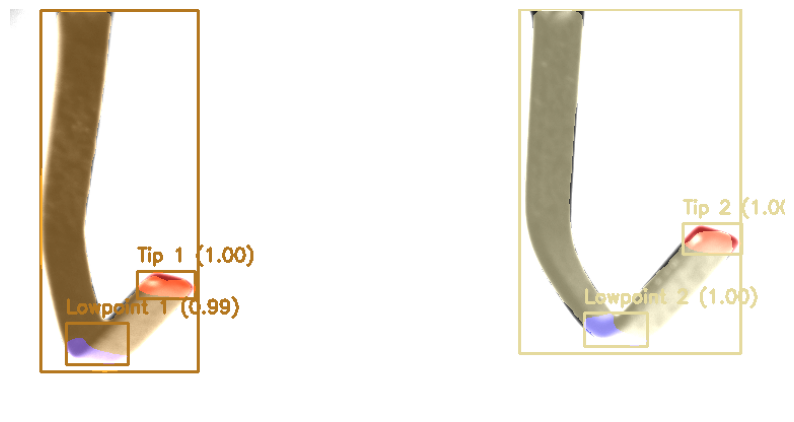

In [39]:
postprocess(results=prediction, show_output_img=True, input_img=np.array(test_img))

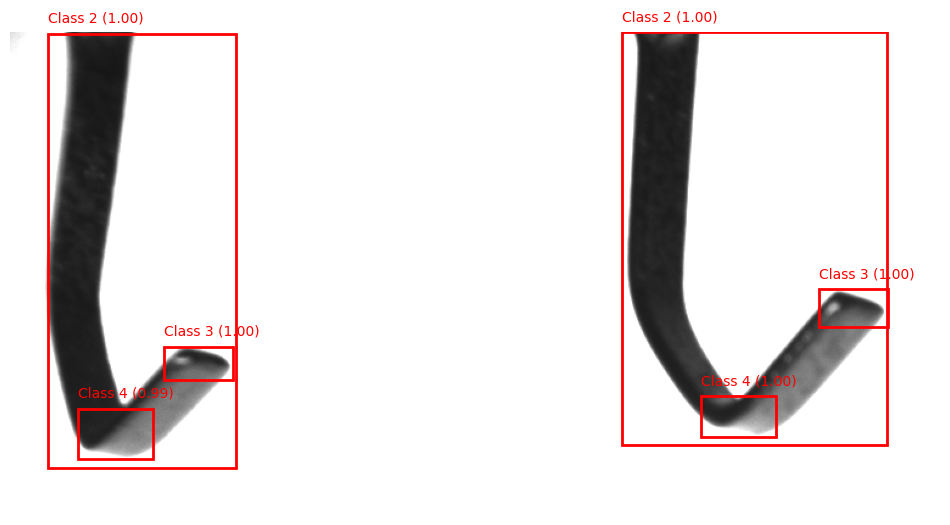

In [40]:
visualize_predictions_with_boxes(np.array(test_img), prediction)

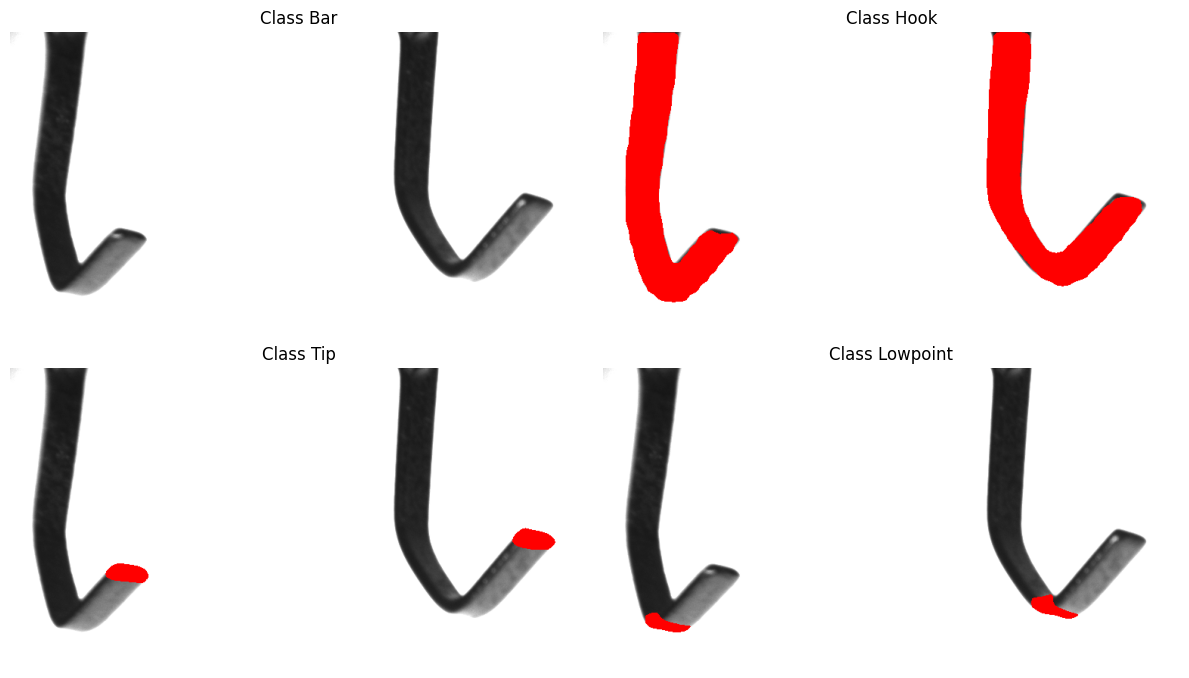

In [41]:
visualize_masks_by_class(np.array(test_img), prediction)